In [1]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [2]:
# Import necessary  libraries

# Initial imports
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
import keras_tuner as kt
%matplotlib inline

import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.1'
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,048 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,903 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/uni

In [3]:
!pip install -q kaggle
from google.colab import drive
import os
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Set paths
kaggle_token_path = '/content/drive/My Drive/kaggle.json'
kaggle_dir = '/root/.kaggle/'

# Check if kaggle directory exists, if not, create it
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)

# Copy kaggle.json from Google Drive to appropriate directory
if os.path.exists(kaggle_token_path):
    shutil.copy(kaggle_token_path, kaggle_dir)
    os.chmod(kaggle_dir + 'kaggle.json', 600)

# Download and unzip dataset
!kaggle datasets download -d alexteboul/diabetes-health-indicators-dataset
!unzip -o diabetes-health-indicators-dataset.zip


Mounted at /content/drive
 83% 5.00M/6.03M [00:00<00:00, 42.3MB/s]
100% 6.03M/6.03M [00:00<00:00, 46.2MB/s]
Archive:  diabetes-health-indicators-dataset.zip
  inflating: diabetes_012_health_indicators_BRFSS2015.csv  
  inflating: diabetes_binary_5050split_health_indicators_BRFSS2015.csv  
  inflating: diabetes_binary_health_indicators_BRFSS2015.csv  


In [4]:
# Initialize Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Kaggle_Dataset") \
    .getOrCreate()

# Load dataset into Spark DataFrame
df = spark.read.csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv", header=True, inferSchema=True)
df.show()

+---------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|Diabetes_binary|HighBP|HighChol|CholCheck| BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex| Age|Education|Income|
+---------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|            0.0|   1.0|     0.0|      1.0|26.0|   0.0|   0.0|                 0.0|         1.0|   0.0|    1.0|              0.0|          1.0|        0.0|    3.0|     5.0|    30.0|     0.0|1.0| 4.0|      6.0|   8.0|
|            0.0|   1.0|     1.0|      1.0|26.0|   1.0|   1.0|                 0.0|         0.0|   1.0|    0.0|              0.0|   

In [5]:
# Show schema to confirm date type
df.printSchema()

root
 |-- Diabetes_binary: double (nullable = true)
 |-- HighBP: double (nullable = true)
 |-- HighChol: double (nullable = true)
 |-- CholCheck: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoker: double (nullable = true)
 |-- Stroke: double (nullable = true)
 |-- HeartDiseaseorAttack: double (nullable = true)
 |-- PhysActivity: double (nullable = true)
 |-- Fruits: double (nullable = true)
 |-- Veggies: double (nullable = true)
 |-- HvyAlcoholConsump: double (nullable = true)
 |-- AnyHealthcare: double (nullable = true)
 |-- NoDocbcCost: double (nullable = true)
 |-- GenHlth: double (nullable = true)
 |-- MentHlth: double (nullable = true)
 |-- PhysHlth: double (nullable = true)
 |-- DiffWalk: double (nullable = true)
 |-- Sex: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Education: double (nullable = true)
 |-- Income: double (nullable = true)



In [6]:
# Convert PySpark DataFrame to Pandas DataFrame
df = df.toPandas()

# Show the first few rows of the DataFrame
df.head()


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [7]:
df.columns

Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [8]:
# Display basic information about the dataset
df.shape

(70692, 22)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

**Random Forests**

In [10]:
# Define features set
X = df.copy()
X.drop("Diabetes_binary", axis=1, inplace=True)
X.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [11]:
y = df["Diabetes_binary"]
y[:5]

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Diabetes_binary, dtype: float64

# **Preprocessing steps**

# Compute the correlation matrix on the entire DataFrame

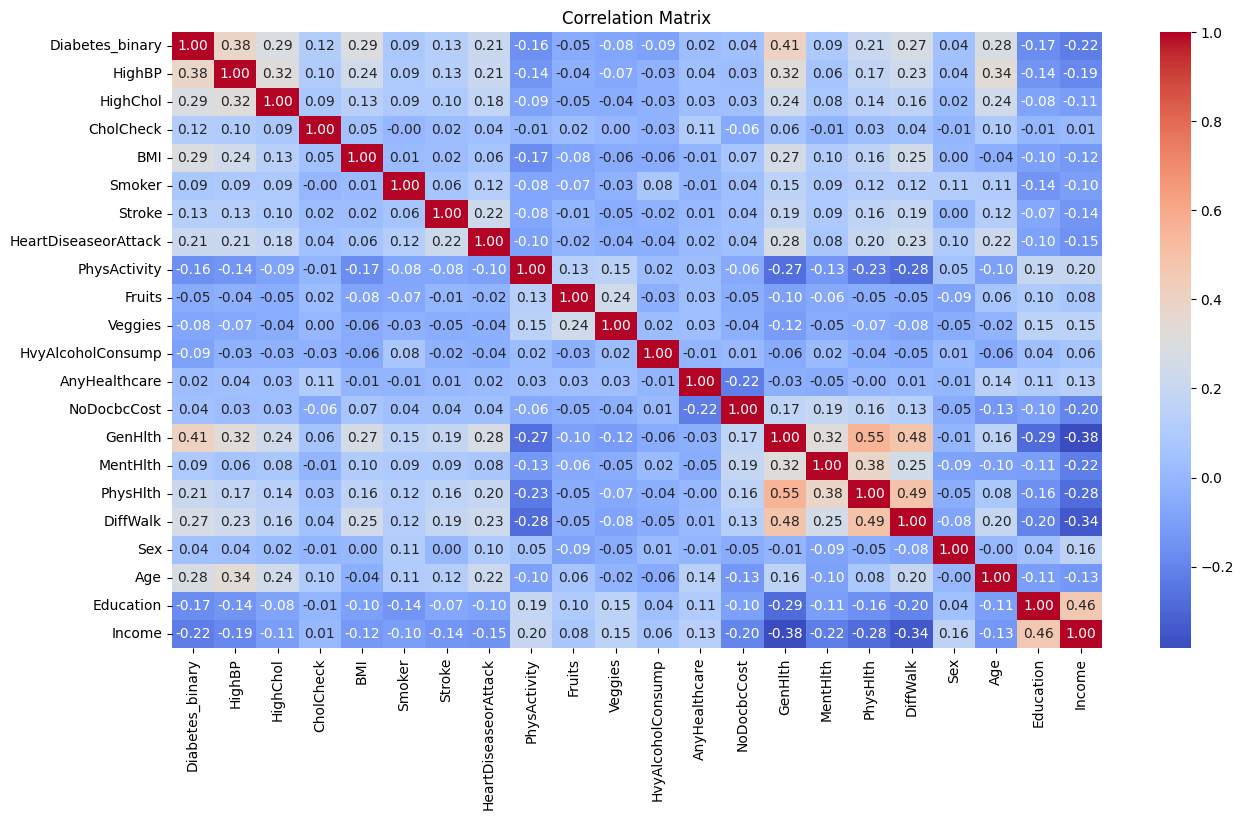

In [12]:
# Compute the correlation matrix on the entire DataFrame
correlation_matrix = df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


# Separate features and target variable

In [13]:
# Separate features and target variable
X = df.drop(columns=['Diabetes_binary'])
y = df['Diabetes_binary']

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to handle class imbalance (if needed)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Define hyperparameters for logistic regression
logreg_params = {
    'C': [0.01, 0.1, 1, 10],  # Reduced range
    'solver': ['liblinear', 'saga']
}

# Perform grid search for logistic regression
logreg_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), logreg_params, cv=3)  # Reduced cv folds
logreg_grid.fit(X_train_resampled, y_train_resampled)

# Get best parameters and train logistic regression with them
best_logreg = logreg_grid.best_estimator_
best_logreg.fit(X_train_resampled, y_train_resampled)

# Make predictions using logistic regression
y_pred_logreg = best_logreg.predict(X_test_scaled)

# Evaluate logistic regression model
print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))
print()

# Define hyperparameters for random forest
rf_params = {
    'n_estimators': [100, 200],  # Reduced number of estimators
    'max_depth': [None, 10, 20]
}

# Perform grid search for random forest
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3)  # Reduced cv folds
rf_grid.fit(X_train_resampled, y_train_resampled)

# Get best parameters and train random forest with them
best_rf = rf_grid.best_estimator_
best_rf.fit(X_train_resampled, y_train_resampled)

# Make predictions using random forest
y_pred_rf = best_rf.predict(X_test_scaled)

# Evaluate random forest model
print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


Logistic Regression Results:
Accuracy: 0.7484263384963576
Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.73      0.74      7090
         1.0       0.74      0.77      0.75      7049

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139

Confusion Matrix:
[[5157 1933]
 [1624 5425]]

Random Forest Results:
Accuracy: 0.7501237711295
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.71      0.74      7090
         1.0       0.73      0.79      0.76      7049

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139

Confusion Matrix:
[[5025 2065]
 [1468 5581]]


**Making Predictions Using the Random Forest Model**

**Feature Importance**

In [14]:
# Random Forests in sklearn will automatically calculate feature importance
importances = best_rf.feature_importances_
# We can sort the features by their importance
sorted_importances = sorted(zip(importances, X.columns), reverse=True)
sorted_importances


[(0.21878532110203397, 'GenHlth'),
 (0.20749668945346397, 'HighBP'),
 (0.14098808292824455, 'BMI'),
 (0.10488796841011158, 'Age'),
 (0.0930697639486474, 'HighChol'),
 (0.048689686554271146, 'DiffWalk'),
 (0.034808914572848036, 'Income'),
 (0.030137164929438295, 'PhysHlth'),
 (0.02856170495028288, 'HeartDiseaseorAttack'),
 (0.014810175613129419, 'Education'),
 (0.012674088122536963, 'MentHlth'),
 (0.012416994562059847, 'PhysActivity'),
 (0.00966805896336014, 'HvyAlcoholConsump'),
 (0.009027043595037905, 'CholCheck'),
 (0.008135847910921562, 'Sex'),
 (0.005949660439454065, 'Stroke'),
 (0.004862476241245927, 'Smoker'),
 (0.00437537228874839, 'Veggies'),
 (0.004197703107713147, 'Fruits'),
 (0.003368047800220031, 'NoDocbcCost'),
 (0.00308923450623086, 'AnyHealthcare')]

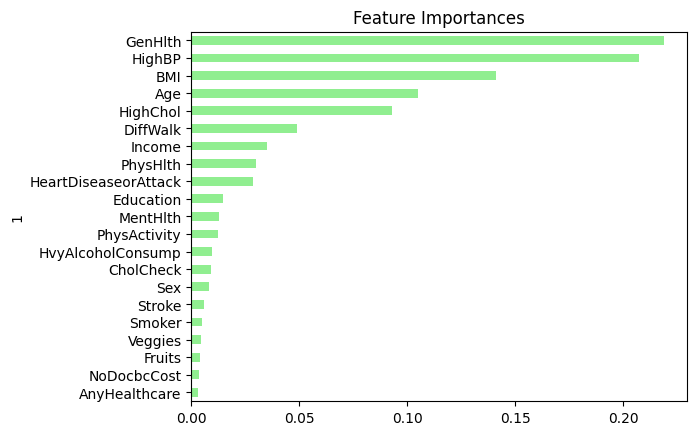

In [15]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(best_rf.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title='Feature Importances', legend=False)
plt.show()


In [16]:
# Define a threshold for feature importance
threshold = 0.05  # Example threshold, adjust as needed

# Get the features with importance scores above the threshold
important_features = [(importance, feature) for importance, feature in sorted(zip(importances, X.columns), reverse=True) if importance >= threshold]

# Extract the feature names from the important features
important_feature_names = [feature for importance, feature in important_features]

# Select columns with importance above the threshold
X_selected = X[important_feature_names]
X_selected


,GenHlth,HighBP,BMI,Age,HighChol
0,3.0,1.0,26.0,4.0,0.0
1,3.0,1.0,26.0,12.0,1.0
2,1.0,0.0,26.0,13.0,0.0
3,3.0,1.0,28.0,11.0,1.0
4,2.0,0.0,29.0,8.0,0.0
...,...,...,...,...,...
70687,4.0,0.0,37.0,6.0,1.0
70688,2.0,0.0,29.0,10.0,1.0
70689,5.0,1.0,25.0,13.0,1.0
70690,4.0,1.0,18.0,11.0,1.0


# Deep Learning Model

In [17]:
!pip install -q -U keras-tuner


Trial 30 Complete [00h 02m 24s]
val_accuracy: 0.7449385523796082

Best val_accuracy So Far: 0.7461763024330139
Total elapsed time: 00h 31m 20s
Epoch 1/20
1414/1414 [==============================] - 7s 4ms/step - loss: 0.5286 - accuracy: 0.7395 - val_loss: 0.5137 - val_accuracy: 0.7421
Epoch 2/20
1414/1414 [==============================] - 4s 3ms/step - loss: 0.5218 - accuracy: 0.7434 - val_loss: 0.5163 - val_accuracy: 0.7418
Epoch 3/20
1414/1414 [==============================] - 4s 3ms/step - loss: 0.5197 - accuracy: 0.7441 - val_loss: 0.5137 - val_accuracy: 0.7473
Epoch 4/20
1414/1414 [==============================] - 5s 4ms/step - loss: 0.5196 - accuracy: 0.7445 - val_loss: 0.5157 - val_accuracy: 0.7439
Epoch 5/20
1414/1414 [==============================] - 4s 3ms/step - loss: 0.5199 - accuracy: 0.7440 - val_loss: 0.5136 - val_accuracy: 0.7426
Epoch 6/20
1414/1414 [==============================] - 4s 3ms/step - loss: 0.5184 - accuracy: 0.7439 - val_loss: 0.5154 - val_accuracy: 

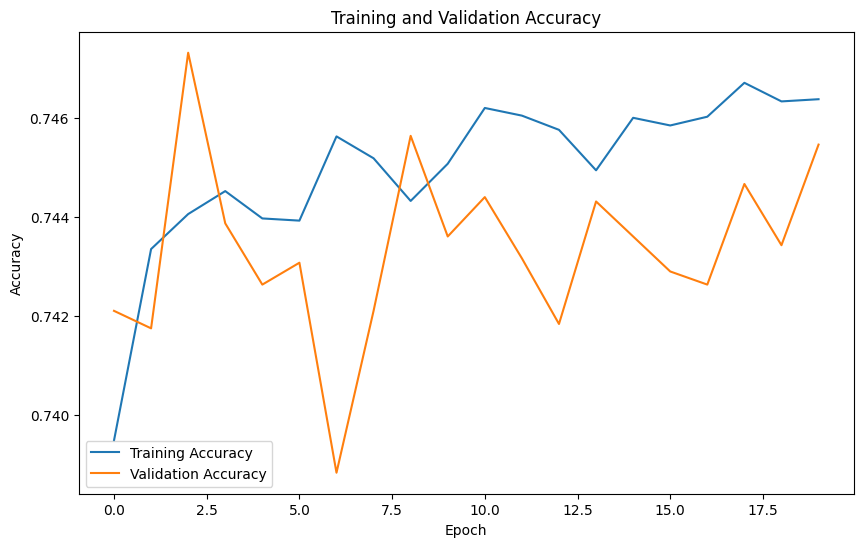

In [18]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define input shape based on the shape of X_train
input_shape = X_train_scaled.shape[1]

# Define a function to build the model
def build_model(hp):
    model = Sequential()

    # Add the input layer
    model.add(Dense(units=hp.Int('input_units', min_value=32, max_value=256, step=32), activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(0.2))  # Add dropout for regularization

    # Add additional hidden layers with different activation functions
    for i in range(hp.Int('num_layers', min_value=1, max_value=3)):
        activation_choice = hp.Choice(f'activation_{i}', values=['relu', 'elu', 'selu'])
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32), activation=activation_choice))
        model.add(Dropout(0.3))  # Add dropout for regularization

    # Add the output layer
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Initialize the tuner with increased max_epochs and/or max_trials
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=20,  # Increase max_epochs
                     factor=3,
                     directory='keras_tuner_logs',
                     project_name='diabetes_prediction')

# Search for the best hyperparameters with increased epochs and/or trials
tuner.search(X_train_scaled, y_train, epochs=10, validation_split=0.2, verbose=1)  # Increase epochs

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model with increased epochs
history = model.fit(X_train_scaled, y_train, epochs=20, validation_split=0.2, verbose=1)  # Increase epochs

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Plot the training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save the model architecture as JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights
model.save_weights("model_weights.h5")


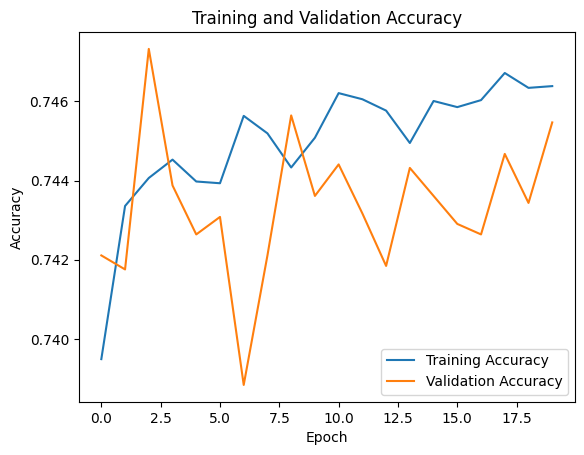

In [20]:
import matplotlib.pyplot as plt

# Visualize training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

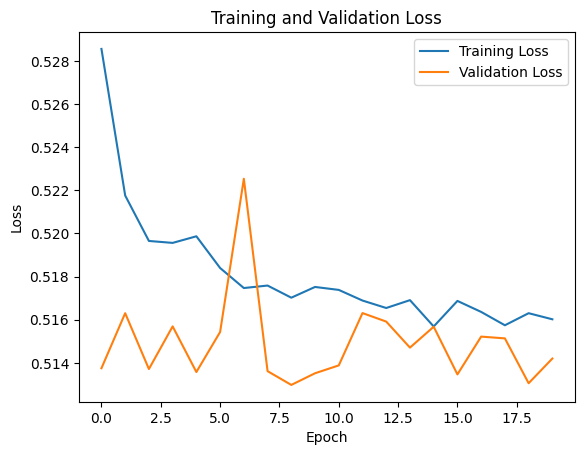

In [21]:
# Visualize training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
# Evaluate the model

# Convert predicted probabilities to class labels
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


442/442 - 1s - loss: 0.5125 - accuracy: 0.7464 - 707ms/epoch - 2ms/step
Test Loss: 0.5124784111976624, Test Accuracy: 0.7464460134506226
442/442 [==============================] - 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.71      0.74      7090
         1.0       0.73      0.78      0.75      7049

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139

Confusion Matrix:
[[5038 2052]
 [1533 5516]]
